In [1]:
from Model.Energy import VonMisesFischerEnergy
from Model.Proposal import VonMisesProposalCartesian
from Data import get_dataloader_from_data
from Model.Energy.utils import get_cartesian_from_polar, get_polar_from_cartesian
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from Model.Trainer import SNLTrainer
from Model.Energy.utils import get_cartesian_from_polar, get_polar_from_cartesian

# Plot sphere in 3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

/opt/miniconda3/envs/lime_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Target Distribution 

In [2]:
target_distribution = torch.distributions.VonMises(torch.tensor([0,0], dtype=torch.float32) , torch.tensor([10,10], dtype=torch.float32))

In [3]:
sample_target_polar = target_distribution.sample((20000,))
print(sample_target_polar.shape)
sample_target_cartesian = get_cartesian_from_polar(sample_target_polar)

# sample_target_cartesian = torch.stack([torch.cos(sample_target_polar[...,0]),
#                                     torch.sin(sample_target_polar[...,0]) * torch.cos(sample_target_polar[...,1]),
#                                     torch.sin(sample_target_polar[...,0]) *torch.sin(sample_target_polar[...,1])
#                                     ], dim=1)

print(sample_target_cartesian.shape)

dataset_total = TensorDataset(sample_target_cartesian, )
data_train, data_val, data_test = torch.utils.data.random_split(dataset_total, [10000, 5000, 5000])
dataloader_train = DataLoader(data_train, batch_size=100, shuffle=True)
dataloader_val = DataLoader(data_val, batch_size=100, shuffle=False)

torch.Size([20000, 2])
torch.Size([20000, 3])


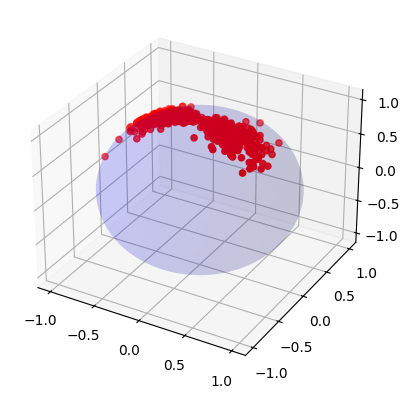

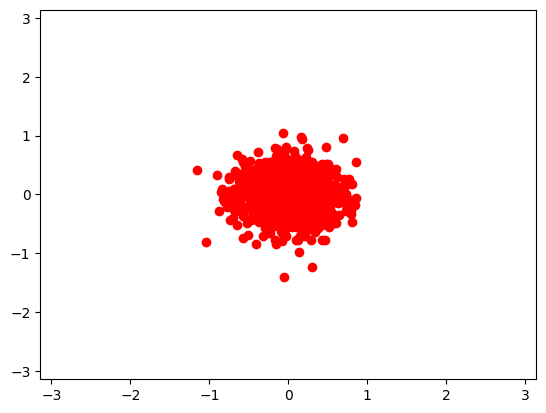

In [4]:

sample_target_polar = target_distribution.sample((1000,))
sample_target_cartesian = get_cartesian_from_polar(sample_target_polar)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_surface(x, y, z, color='b', alpha=0.1)
# Add points
ax.scatter(*sample_target_cartesian.T, color='r')
plt.show()


# Plot sphere polar projection
fig, ax = plt.subplots()
ax.scatter(sample_target_polar[...,0], sample_target_polar[...,1], color='r')
plt.xlim(-np.pi, np.pi)
plt.ylim(-np.pi, np.pi)
plt.show()




# Proposal Distribution :

Init Standard Gaussian...
tensor(-3.1387) tensor(3.1384)
tensor(0.0016) tensor(3.1356)


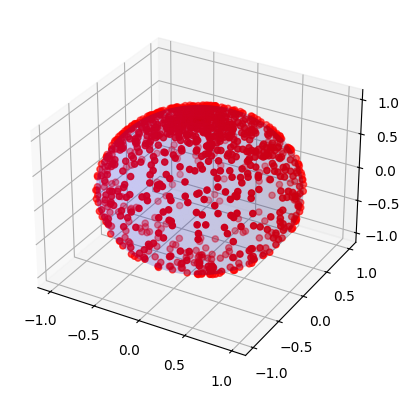

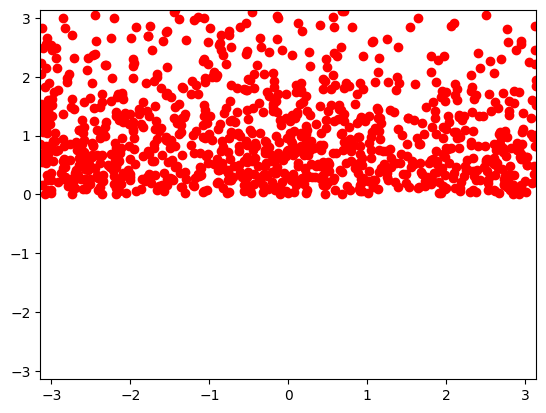

In [5]:
proposal_distribution = VonMisesProposalCartesian(input_size= torch.Size([3,]), phi = torch.tensor([0,0], dtype=torch.float32), kappa= torch.tensor([1,1], dtype=torch.float32))
sample_proposal_cartesian = proposal_distribution.sample(1000,)
sample_proposal_polar = get_polar_from_cartesian(sample_proposal_cartesian)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_surface(x, y, z, color='b', alpha=0.1)

# Add points
ax.scatter(*sample_proposal_cartesian.T, color='r')
plt.show()

# Plot sphere polar projection
fig, ax = plt.subplots()
ax.scatter(sample_proposal_polar[...,0], sample_proposal_polar[...,1], color='r')
plt.xlim(-np.pi, np.pi)
plt.ylim(-np.pi, np.pi)
plt.show()



# Energy

In [6]:
energy = VonMisesFischerEnergy(dim=2, learn_mu=True, learn_kappa=True)

In [7]:
energy(x = sample_target_cartesian)

tensor([-2.1069, -1.3057, -1.7169, -0.7272, -1.3877, -1.4713, -1.3171, -2.1000,
        -1.4222, -1.8664, -1.7223, -1.3912, -2.4020, -1.8580, -0.3616, -1.4655,
        -1.5576, -1.9399, -1.9672, -1.6301, -0.8024, -1.7456, -2.0218, -1.5403,
        -1.2413, -1.7177, -1.9372, -1.0107, -1.7223, -1.6768, -1.0926, -1.8864,
        -1.4351, -0.7587, -1.8485, -2.0177, -1.3052, -2.0568, -0.9785, -1.8556,
        -1.6471, -1.2378, -0.8513, -1.5382, -0.9021, -1.5138, -2.0286, -1.4181,
        -1.5625, -1.5923, -0.6886, -1.8540, -1.5397, -2.1324, -1.4818,  0.1542,
        -2.0102, -1.4995, -0.3761, -1.2367, -2.0656, -1.8500, -1.7549, -1.4656,
        -1.4117, -1.4800, -1.5465, -1.0143, -1.8629, -1.6054, -2.1284, -2.1443,
         0.0033, -1.5985, -1.6696, -1.2674, -1.7648, -0.8789, -0.2338, -1.3716,
        -1.2338, -1.4253, -1.4179, -1.1955, -1.3950, -1.5228, -2.2779, -1.2292,
        -1.5581, -0.3912, -1.6491, -2.2501, -1.3016, -1.8044, -1.4736, -1.4823,
        -1.6330, -2.0323, -1.5127, -0.89

# Trainer :


In [8]:
trainer = SNLTrainer(energy=energy, proposal=proposal_distribution, dataloader=dataloader_train, val_dataloader=dataloader_val , n_sample_train=1000, n_sample_test=1000, lr=0.01, )

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hugosenetaire. Use `wandb login --relogin` to force relogin


In [9]:
trainer.train(n_iter=30000, n_iter_pretrain=1000,)

tensor(nan) tensor(nan)
tensor(0.) tensor(3.1338)


ValueError: Expected value argument (Tensor of shape (1000, 2)) to be within the support (Real()) of the distribution VonMises(loc: torch.Size([2]), concentration: torch.Size([2])), but found invalid values:
tensor([[ 0.5015,  0.0234],
        [-2.1652,  0.0414],
        [-0.2469,  0.8322],
        ...,
        [ 0.8715,  2.0046],
        [ 2.4775,  0.5094],
        [-2.6318,  0.8604]])

wandb: Network error (ConnectionError), entering retry loop.
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-inte